# Rethinking Statistics course in NumPyro - Week 1

Lecture 1: The Golem of Prague

- [Video](https://youtu.be/cclUd_HoRlo)
- [Slides](https://speakerdeck.com/rmcelreath/statistical-rethinking-2022-lecture-01)

Lecture 2: Bayesian Inference

- [Video](https://www.youtube.com/watch?v=guTdrfycW2Q&list=PLDcUM9US4XdMROZ57-OIRtIK0aOynbgZN&index=2)
- [Slides](https://speakerdeck.com/rmcelreath/statistical-rethinking-2022-lecture-02)

[Proposed problems](https://github.com/rmcelreath/stat_rethinking_2022/blob/main/homework/week01.pdf) and [solutions in R](https://github.com/rmcelreath/stat_rethinking_2022/blob/main/homework/week01_solutions.pdf) for the exercises of the week.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Jan 23 2022

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 8.0.1

seaborn   : 0.11.1
scipy     : 1.6.1
sys       : 3.8.10 (default, Nov 26 2021, 20:14:08) 
[GCC 9.3.0]
numpy     : 1.20.1
matplotlib: 3.3.4
pandas    : 1.2.3

Watermark: 2.2.0



In [3]:
sns.set_style('whitegrid')

## Short Intro

In this short intro, I just play around a bit with the concepts of prior and posterior. I calculate manually both for the very simple glob tossing example mentioned in the lecture. You can jump to the actual homework going to the next section.

In [4]:
n=9    # tosses
k=6    # water
p=0.5  # water probability

How to generate binomials with `numpy`:

In [5]:
stats.binom.rvs(1, p, size=9)

array([1, 0, 0, 0, 0, 0, 0, 0, 0])

Density function of a binomial:

In [6]:
round(stats.binom.pmf(k, n, p), 2)

0.16

Example:

In [7]:
def posterior_grid_binomial(n, k, s):
    """Posterior sample of binomial distribution using grid integration.

    Args:
        n (int): trials
        k (int): successes
        s (int): probability grid discretization

    Returns:
        posteriors (ndarray): posterior probabilities
    """
    p_grid = np.linspace(0,1,s)
    priors = np.ones(s)
    likelihoods = stats.binom.pmf(k, n, p=p_grid)
    posteriors = priors * likelihoods
    posteriors = posteriors / sum(posteriors) # normalizing the posteriors
    return posteriors

In [8]:
n=9
k=6
s=50
posterior = posterior_grid_binomial(n, k, s)
sum(posterior)

1.0

Looks good. Plotting the posterior:

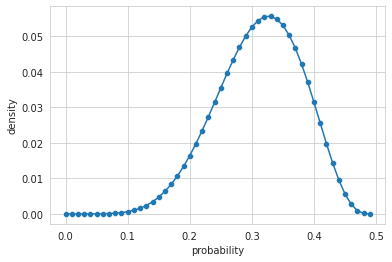

In [9]:
aux = pd.DataFrame(posterior).rename({0:'prob'}, axis=1)
aux['p'] = aux.index/100
g = sns.lineplot(data=aux, x='p',y='prob')
sns.scatterplot(data=aux, x='p',y='prob', ax=g)
g.set(xlabel='probability', ylabel='density');

Nice! Let's sample the posterior we just got:

In [10]:
import jax

In [11]:
p_grid = np.linspace(0,1,s)
samples = (pd.DataFrame(np.random.choice(p_grid, 5000, p=posterior))
            .reset_index()
            .rename({0:'prob'}, axis=1)
          )
samples.tail(3) # just to see how it looks

,index,prob
4997,4997,0.591837
4998,4998,0.816327
4999,4999,0.795918


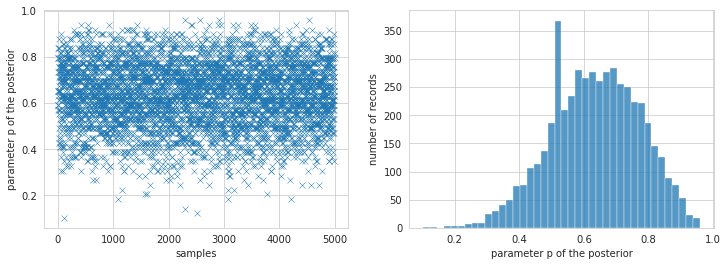

In [12]:
fig, axs = plt.subplots(ncols=2)
s = sns.scatterplot(data=samples, x='index', y='prob', marker='x', ax=axs[0])
s.set(xlabel='samples', ylabel='parameter p of the posterior')
h = sns.histplot(data=samples, x='prob', ax=axs[1])
h.set(xlabel='parameter p of the posterior', ylabel='number of records')
fig.set_size_inches(12,4)

You can think of the first plot as a bird view of the second one (shifted 90 degrees). Let's calculate the credible intervals.

In [13]:
round(np.percentile(samples.prob.values, 2.5),2), round(np.percentile(samples.prob.values, 97.5),2)

(0.35, 0.88)

## Exercise 1

>Suppose the globe tossing data had turned out to be 8 water in 15 tosses. Construct the posterior distribution, using grid approximation. Use the same flat prior as before.

Really all you need is to modify the grid approximation code in Chapter 3 (there are constant references to the book that I will keep just in case you gusy want to check them out). If you replace 6 with 8 and 9 with 15, it'll work:

In [14]:
n = 15
k = 8
s = 101

p_grid_1 = np.linspace(0,1,s)
posterior_1 = posterior_grid_binomial(n, k, s)

samples = (pd.DataFrame(np.random.choice(p_grid_1, 5000, p=posterior_1))
           .reset_index()
           .rename({0:'prob'}, axis=1)
          )

The posterior mean should be about 0.53 and the 99% percentile interval from 0.24 to 0.81.

In [15]:
round(np.mean(samples.prob),2)

0.53

In [16]:
round(np.percentile(samples.prob.values, 0.5),2), round(np.percentile(samples.prob.values, 99.5),2)

(0.23, 0.81)

## Exercise 2

>Start over in 1, but now use a prior that is zero below $p = 0.5$ and a constant above $p = 0.5$. This corresponds to prior information that a majority of the Earth's surface is water. What difference does the better prior make? If it helps, compare posterior distributions (using both priors) to the true value $p = 0.7$.

Modifying only the prior:

In [17]:
n = 15
k = 8

p_grid_2 = np.linspace(0,1,101)
prob_p = np.concatenate((np.zeros(50), np.full(51,0.5)))
prob_data = stats.binom.pmf(k, n, p=p_grid_2)
posterior_2 = prob_data * prob_p
posterior_2 = posterior_2 / sum(posterior_2)

samples = (pd.DataFrame(np.random.choice(p_grid_2, 5000, p=posterior_2))
           .reset_index()
           .rename({0:'prob'}, axis=1)
          )

The posterior mean should be about 0.61 and the 99% interval 0.50 to 0.82. This prior yields a posterior with more mass around the true value of 0.7.

In [18]:
round(np.mean(samples.prob),2)

0.6

In [19]:
round(np.quantile(samples.prob.values, 0.005), 2), round(np.quantile(samples.prob.values, 0.995), 2)

(0.5, 0.82)

This is probably easier to see in a plot:

In [20]:
# some data wrangling to prepate the plot
aux = pd.DataFrame(posterior_1).rename({0:'prob'}, axis=1)
aux['p'] = aux.index/100
aux['posterior'] = 'posterior1'

aux2 = pd.DataFrame(posterior_2).rename({0:'prob'}, axis=1)
aux2['p'] = aux2.index/100
aux2['posterior'] = 'posterior2'

aux = pd.concat([aux, aux2], axis=0)
aux.head(3)

,prob,p,posterior
0,0.000000e+00,0.00,posterior1
1,9.596545e-14,0.01,posterior1
2,2.288184e-11,0.02,posterior1


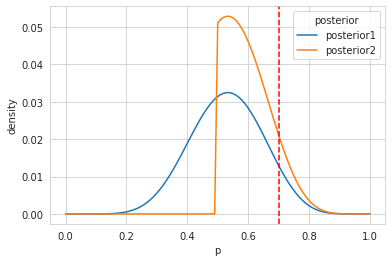

In [21]:
g = sns.lineplot(data=aux, x='p', y='prob', hue='posterior')
g.set(xlabel='p', ylabel='density')
g.axvline(0.7, ls='--', c='r');

With the impossible values less than 0.5 ruled out, the second model piles up more plausibility on the higher values near the true value. The data are
still misleading it to think that values just above 0.5 are the most plausible. But the posterior mean of 0.63 is much better than 0.53 from the previous
problem. Informative priors, when based on real scientific information, help. Here, the informative prior helps because there isn't much data. That is common in a lot of fields, ranging from astronomy to paleontology

## Exercise 3

>This problem is more open-ended than the others. Feel free to collaborate on the solution. Suppose you want to estimate the Earth's proportion of water very precisely. Specifically, you want the 99% percentile interval of the posterior distribution of p to be only 0.05 wide. This means the distance between the upper and lower bound of the interval should be 0.05. How many times will you have to toss the globe to do this? I won't require a precise answer. I'm honestly more interested in your approach.

One way to approach this problem is to try a range of sample sizes and to plot the interval width of each. Here's some code to compute the posterior and get the interval width. There are other ways to compute the interval width. But the former is closest to the code in the book. Now since we want to do this for different values of $N$, it's nice to make this into a function. Now if you enter binomial_grid_posterior(20), you get an interval width for 20 globe tosses. Now notice that the interval width varies across simulations. As you increase N, this variation shrinks rapidly. This is because as the sample size increases, the differences between samples shrink. Now we need to run simulations across a bunch of different sample size to find where the interval shrinks to 0.05 in width.

In [22]:
p=0.7
s=1001
akk = []
for n in [100, 1000, 10000, 100000]:
    k=sum(np.random.binomial(1, p, n))
    p_grid_3 = np.linspace(0,1,s)
    posterior_3 = posterior_grid_binomial(n, k, s)
    samples = (pd.DataFrame(np.random.choice(p_grid_3, 5000, p=posterior_3))
               .reset_index()
               .rename({0:'prob'}, axis=1)
               .assign(n=n)
              )
    akk.append(samples)
    print(f'Distribution size: {n}, PI(0.5, 99.5): {np.round(np.quantile(samples.prob.values, 0.05), 3), np.round(np.quantile(samples.prob.values, 0.95), 3)}')
all_samples = pd.concat(akk).drop(['index'], axis=1)

Distribution size: 100, PI(0.5, 99.5): (0.704, 0.839)
Distribution size: 1000, PI(0.5, 99.5): (0.684, 0.731)
Distribution size: 10000, PI(0.5, 99.5): (0.691, 0.706)
Distribution size: 100000, PI(0.5, 99.5): (0.698, 0.703)


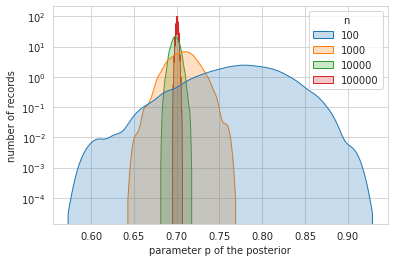

In [23]:
h = sns.kdeplot(data=all_samples, x='prob', hue='n', palette='tab10', shade=True)
h.set(xlabel='parameter p of the posterior', ylabel='number of records', yscale='log');

Looks like we need more than 2000 tosses of the globe to get the interval to be that precise. The above is a general feature of learning from data: The greatest returns on learning come early on. Each additional observation contributes less and less. So it takes very much effort to progressively reduce our uncertainty. So if your application requires a very precise estimate, be prepared to collect a lot of data. Or to change your approach.